# Loan Prediction 

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, auc, mutual_info_score
)

In [2]:
df = pd.read_csv("loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## EDA

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2,)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,)
len(df_train), len(df_val), len(df_test)

(27000, 9000, 9000)

In [5]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [6]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

In [7]:
del df_train["loan_status"]
del df_val["loan_status"]
del df_test["loan_status"]

In [8]:
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
num_cols = [var for var in df.columns if df[var].dtypes != 'object']

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


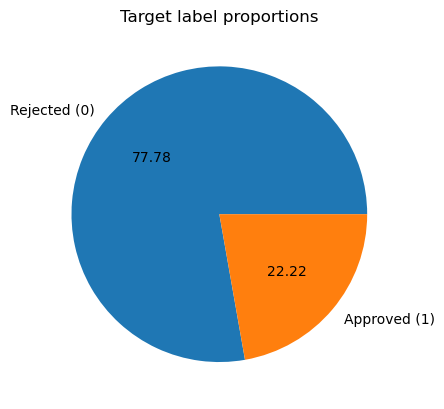

In [9]:
label_prop = df["loan_status"].value_counts()

plt.pie(label_prop.values, labels=["Rejected (0)", "Approved (1)"], autopct="%.2f")
plt.title("Target label proportions")
plt.show()

In [10]:
global_loan_rate = (df_full_train.loan_status.mean())

female_loan = df_full_train[df_full_train.person_gender == "female"].loan_status.mean()
male_loan = df_full_train[df_full_train.person_gender == "male"].loan_status.mean()

print(f" Female Loan rate: {female_loan:.3f}\n Male Loan rate: {male_loan:.3f}\n Global Loan rate:  {global_loan_rate:.3f}")

 Female Loan rate: 0.223
 Male Loan rate: 0.221
 Global Loan rate:  0.222


In [11]:
from IPython.display import display

for c in cat_cols:
    print(c)
    df_group = df_full_train.groupby(c).loan_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_loan_rate
    df_group['risk'] = df_group['mean'] / global_loan_rate
    display(df_group)
    print("\n\n")

person_gender


,mean,count,diff,risk
person_gender,,,,
female,0.222966,16128,0.000911,1.004101
male,0.221316,19872,-0.000739,0.996671





person_education


,mean,count,diff,risk
person_education,,,,
Associate,0.221140,9650,-0.000916,0.995876
Bachelor,0.223460,10682,0.001404,1.006325
Doctorate,0.220648,494,-0.001408,0.993660
High School,0.222999,9583,0.000944,1.004249
Master,0.219460,5591,-0.002596,0.988311





person_home_ownership


,mean,count,diff,risk
person_home_ownership,,,,
MORTGAGE,0.116086,14851,-0.105969,0.522781
OTHER,0.325581,86,0.103526,1.466216
OWN,0.074432,2378,-0.147623,0.335197
RENT,0.324592,18685,0.102536,1.461760





loan_intent


,mean,count,diff,risk
loan_intent,,,,
DEBTCONSOLIDATION,0.301399,5720,0.079343,1.357312
EDUCATION,0.167121,7342,-0.054935,0.752607
HOMEIMPROVEMENT,0.261526,3839,0.039471,1.177752
MEDICAL,0.279138,6821,0.057082,1.257064
PERSONAL,0.203893,6062,-0.018162,0.918208
VENTURE,0.144627,6216,-0.077429,0.651309





previous_loan_defaults_on_file


,mean,count,diff,risk
previous_loan_defaults_on_file,,,,
No,0.449505,17784,0.227450,2.024291
Yes,0.000000,18216,-0.222056,0.000000


In [12]:
mi = {}
for c in cat_cols:
    mi[c] = mutual_info_score(df_full_train[c], df_full_train.loan_status)

pd.Series(mi).sort_values(ascending=False)

previous_loan_defaults_on_file    0.189606
person_home_ownership             0.035234
loan_intent                       0.010217
person_education                  0.000006
person_gender                     0.000002
dtype: float64

In [13]:
num_cols_for_mi = [c for c in num_cols if c != "loan_status"]
mi_scores = mutual_info_classif(df_full_train[num_cols_for_mi], df_full_train.loan_status)

mi = dict(zip(num_cols_for_mi, mi_scores))
pd.Series(mi).sort_values(ascending=False)

person_income                 0.092024
loan_percent_income           0.082410
loan_int_rate                 0.071160
loan_amnt                     0.020565
credit_score                  0.002191
person_emp_exp                0.000172
person_age                    0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [14]:
df_full_train[num_cols].corrwith(df_full_train.loan_status)

person_age                   -0.023532
person_income                -0.132510
person_emp_exp               -0.022304
loan_amnt                     0.106590
loan_int_rate                 0.332041
loan_percent_income           0.383930
cb_person_cred_hist_length   -0.018524
credit_score                 -0.010359
loan_status                   1.000000
dtype: float64

## One hot encoding

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat_cols + num_cols_for_mi].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Model

In [16]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/manu/miniconda3/envs/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
y_pred = model.predict_proba(X_val)[:, 1]

loan_des = (y_pred >= 0.5)

(y_val == loan_des).mean()

np.float64(0.8442222222222222)

In [18]:
from sklearn.metrics import accuracy_score

scores = []
thresholds = np.linspace(0, 1, 21)

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.215
0.05 0.450
0.10 0.584
0.15 0.666
0.20 0.726
0.25 0.765
0.30 0.796
0.35 0.819
0.40 0.833
0.45 0.841
0.50 0.844
0.55 0.839
0.60 0.836
0.65 0.830
0.70 0.822
0.75 0.813
0.80 0.804
0.85 0.797
0.90 0.789
0.95 0.785
1.00 0.785


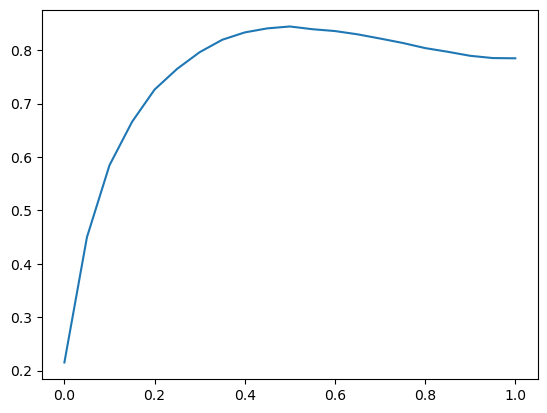

In [19]:
plt.plot(thresholds, scores)

## Model Evaluation Metrics

In [29]:
y_pred_binary = (y_pred >= 0.5).astype(int)

metrics = {
    "Accuracy": accuracy_score(y_val, y_pred_binary),
    "Precision": precision_score(y_val, y_pred_binary),
    "Recall": recall_score(y_val, y_pred_binary),
    "F1-Score": f1_score(y_val, y_pred_binary),
    "ROC-AUC": roc_auc_score(y_val, y_pred)
}

metrics_summary = (
    pd.Series(metrics, name="Score")
      .rename_axis("Metric")
      .reset_index()
)

print("Validation snapshot")
print(metrics_summary.to_string(index=False))


Validation snapshot
   Metric    Score
 Accuracy 0.844222
Precision 0.712698
   Recall 0.463364
 F1-Score 0.561601
  ROC-AUC 0.843101



CONFUSION MATRIX:
[[6700  362]
 [1040  898]]

Interpretation:
True Negatives (TN):  6700
False Positives (FP): 362
False Negatives (FN): 1040
True Positives (TP):  898


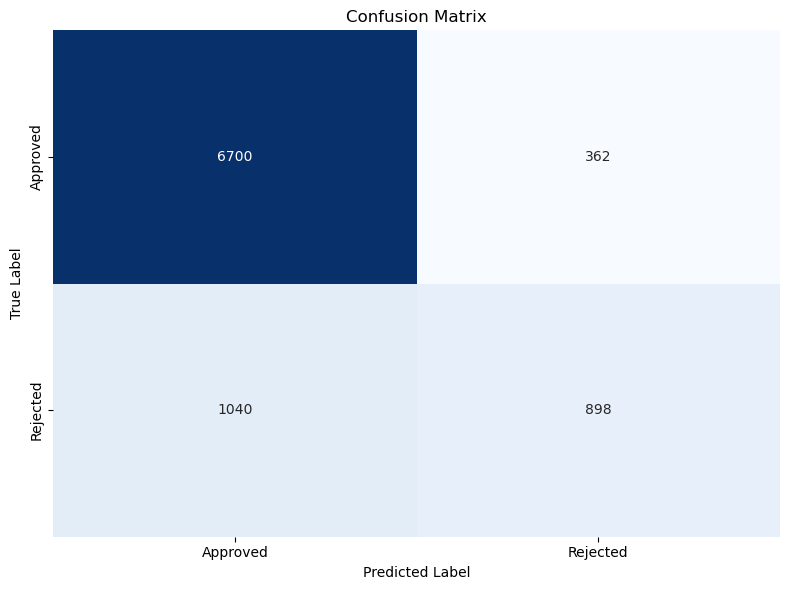

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_binary)
print("\nCONFUSION MATRIX:")
print(cm)
print("\nInterpretation:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Approved', 'Rejected'],
            yticklabels=['Approved', 'Rejected'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val, y_pred_binary, 
                           target_names=['Approved (0)', 'Rejected (1)']))



DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Approved (0)       0.87      0.95      0.91      7062
Rejected (1)       0.71      0.46      0.56      1938

    accuracy                           0.84      9000
   macro avg       0.79      0.71      0.73      9000
weighted avg       0.83      0.84      0.83      9000



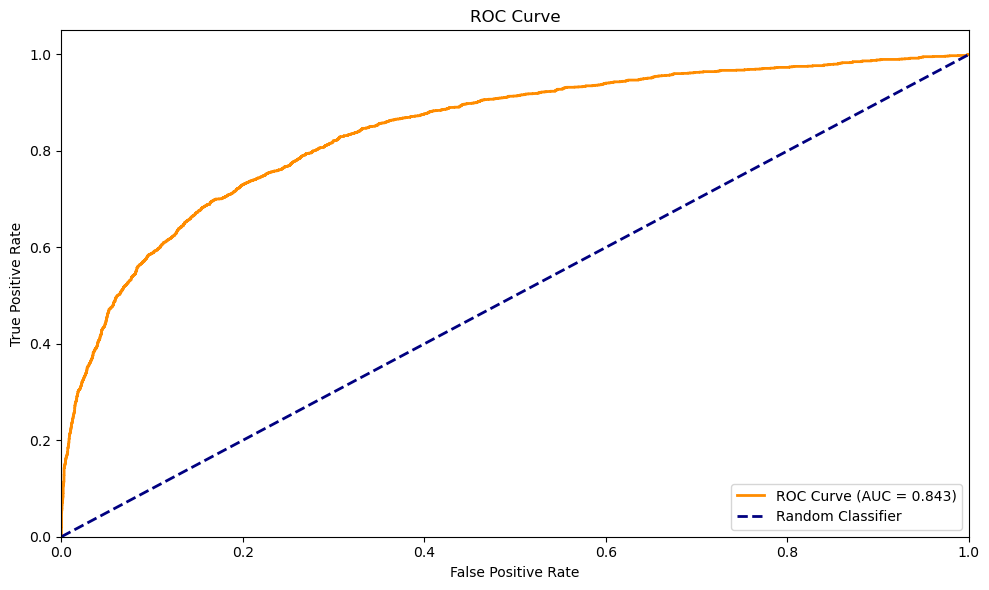

In [23]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Trying different models